In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import theano
print("Theano version:",theano.__version__)
import sys
print (sys.version)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Couldn't import dot_parser, loading of dot files will not be possible.
Theano version: 0.9.0
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


## Grab the input data

In [3]:
!./grab_data.sh

File task0importancescores.npy exists already
File task0hypimpscores.npy exists already
File sequences.txt exists already


### Functions for one-hot encoding sequences

In [3]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip("\n") for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split("\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta)

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences]

Double check by plotting

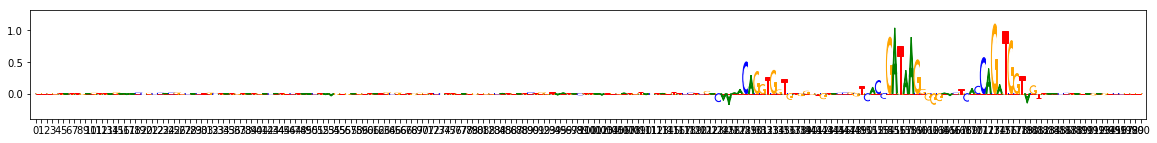

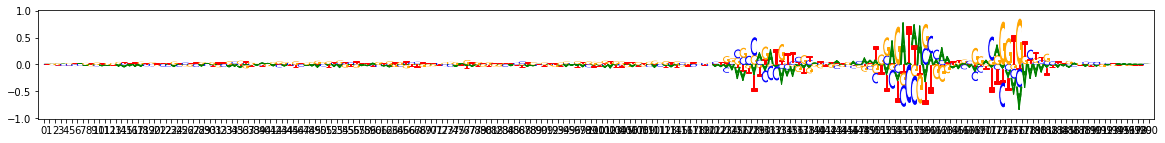

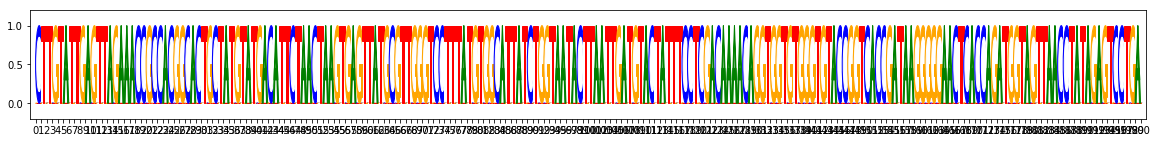

In [10]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there is just one task, there are only 2 possible metaclusters: +1 for the task and -1 for the task. The -1 metacluster does not turn up any motifs after noise filtering, but the +1 metacluster produces two motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.

On task task0
Computing windowed sums
Computing threshold


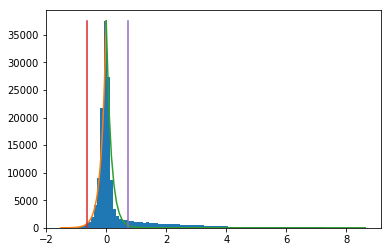

Computed thresholds -0.6416454084537142 and 0.7205877237219461
Got 1657 coords
On task task1
Computing windowed sums
Computing threshold


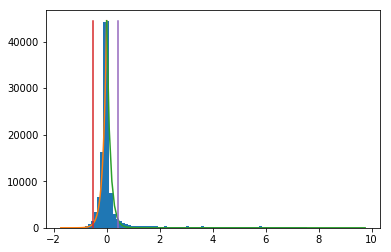

Computed thresholds -0.5160286106142382 and 0.44716295636005515
Got 1465 coords
On task task2
Computing windowed sums
Computing threshold


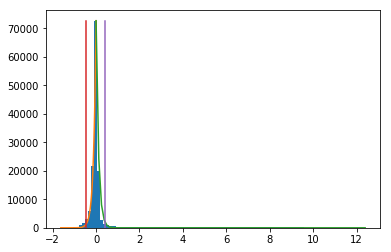

Computed thresholds -0.4456595157624062 and 0.4247654976999513
Got 1546 coords
After resolving overlaps, got 2499 seqlets
6 activity patterns with support >= 200 out of 27 possible patterns
Metacluster sizes:  [799, 692, 311, 248, 235, 205]
Idx to activities:  {0: '1,0,1', 1: '1,1,0', 2: '0,1,0', 3: '0,0,-1', 4: '0,0,1', 5: '0,-1,0'}
On metacluster 5
Metacluster size 205
Relevant tasks:  ('task1',)
Relevant signs:  (-1,)
(Round 1) num seqlets: 205
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.25 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 1) Computing affinity matrix on nearest neighbors
Launching nearest neighbors affmat calcula

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.8s finished


Louvain completed 200 runs in 1.10474896431 seconds
Wrote graph to binary file in 0.0126080513 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.734957
After 31 runs, maximum modularity is Q = 0.735555
After 56 runs, maximum modularity is Q = 0.73796
Louvain completed 106 runs in 1.24083590508 seconds
Preproc + Louvain took 2.4100651741 s
Got 9 clusters after round 1
Counts:
{0: 27, 1: 22, 2: 20, 3: 19, 4: 17, 5: 15, 6: 13, 7: 12, 8: 11}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 27 seqlets
Trimmed 2 out of 27
Skipped 2 seqlets
Dropping cluster 0 with 23 seqlets due to sign disagreement
Aggregating for cluster 1 with 22 seqlets
Trimmed 0 out of 22
Skipped 2 seqlets
Aggregating for cluster 2 with 20 seqlets
Trimmed 6 out of 20
Skipped 1 seqlets
Aggregating for cluster 3 with 19 seqlets
Trimmed 0 out of 19
Aggregating for cluster 4 with 17 seqlets
Trimmed 0 out of 17
Aggregating for cluster 5 with 15 seqlets
Trimme

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.09445691109 seconds
Wrote graph to binary file in 0.00670194625854 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.850378
Louvain completed 51 runs in 0.594808101654 seconds
Preproc + Louvain took 1.73250293732 s
Got 11 clusters after round 2
Counts:
{0: 15, 1: 14, 2: 14, 3: 11, 4: 11, 5: 10, 6: 10, 7: 9, 8: 9, 9: 8, 10: 7}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 15 seqlets
Trimmed 0 out of 15
Aggregating for cluster 1 with 14 seqlets
Trimmed 1 out of 14
Aggregating for cluster 2 with 14 seqlets
Trimmed 0 out of 14
Aggregating for cluster 3 with 11 seqlets
Trimmed 0 out of 11
Aggregating for cluster 4 with 11 seqlets
Trimmed 0 out of 11
Aggregating for cluster 5 with 10 seqlets
Trimmed 0 out of 10
Aggregating for cluster 6 with 10 seqlets
Trimmed 1 out of 10
Aggregating for cluster 7 with 9 seqlets
Trimmed 0 out of 9
Aggregating for cluster 8 with 9 seqlets
Trimmed 0 out of 9


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.0s finished


Louvain completed 200 runs in 1.23789691925 seconds
Wrote graph to binary file in 0.0184350013733 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.654218
Louvain completed 51 runs in 0.642953157425 seconds
Preproc + Louvain took 1.95623803139 s
Got 7 clusters after round 1
Counts:
{0: 62, 1: 40, 2: 32, 3: 30, 4: 24, 5: 10, 6: 6}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 62 seqlets
Trimmed 8 out of 62
Skipped 6 seqlets
Aggregating for cluster 1 with 40 seqlets
Trimmed 3 out of 40
Skipped 2 seqlets
Aggregating for cluster 2 with 32 seqlets
Trimmed 2 out of 32
Skipped 1 seqlets
Aggregating for cluster 3 with 30 seqlets
Trimmed 4 out of 30
Skipped 1 seqlets
Aggregating for cluster 4 with 24 seqlets
Trimmed 3 out of 24
Aggregating for cluster 5 with 10 seqlets
Trimmed 1 out of 10
Aggregating for cluster 6 with 6 seqlets
Trimmed 0 out of 6
(Round 2) num seqlets: 173
(Round 2) Computing coarse affmat
Beginning embeddi

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.14537286758 seconds
Wrote graph to binary file in 0.0167191028595 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.599472
After 6 runs, maximum modularity is Q = 0.627821
Louvain completed 56 runs in 0.69113111496 seconds
Preproc + Louvain took 1.90172886848 s
Got 5 clusters after round 2
Counts:
{0: 69, 1: 40, 2: 25, 3: 23, 4: 16}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 69 seqlets
Trimmed 1 out of 69
Skipped 1 seqlets
Aggregating for cluster 1 with 40 seqlets
Trimmed 4 out of 40
Aggregating for cluster 2 with 25 seqlets
Trimmed 2 out of 25
Skipped 2 seqlets
Aggregating for cluster 3 with 23 seqlets
Trimmed 2 out of 23
Aggregating for cluster 4 with 16 seqlets
Trimmed 0 out of 16
Got 5 clusters
Splitting into subclusters...
Inspecting for spurious merging
Wrote graph to binary file in 0.00603294372559 seconds
Running Louvain modularity optimization
After 1 runs, maximum modular

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.21992492676 seconds
Wrote graph to binary file in 0.0136568546295 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.770959
After 2 runs, maximum modularity is Q = 0.774645
After 3 runs, maximum modularity is Q = 0.77544
After 21 runs, maximum modularity is Q = 0.780704
Louvain completed 71 runs in 0.917655944824 seconds
Preproc + Louvain took 2.1979970932 s
Got 10 clusters after round 1
Counts:
{0: 27, 1: 26, 2: 26, 3: 24, 4: 19, 5: 19, 6: 16, 7: 15, 8: 13, 9: 8}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 27 seqlets
Trimmed 9 out of 27
Dropping cluster 0 with 18 seqlets due to sign disagreement
Aggregating for cluster 1 with 26 seqlets
Trimmed 0 out of 26
Aggregating for cluster 2 with 26 seqlets
Trimmed 0 out of 26
Skipped 1 seqlets
Aggregating for cluster 3 with 24 seqlets
Trimmed 7 out of 24
Aggregating for cluster 4 with 19 seqlets
Trimmed 0 out of 19
Aggregating for cluster 5 

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    0.9s finished


Louvain completed 200 runs in 1.23271298409 seconds
Wrote graph to binary file in 0.0117020606995 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.718006
After 2 runs, maximum modularity is Q = 0.730313
After 36 runs, maximum modularity is Q = 0.730569
Louvain completed 86 runs in 1.01526999474 seconds
Preproc + Louvain took 2.29759001732 s
Got 9 clusters after round 2
Counts:
{0: 31, 1: 22, 2: 18, 3: 18, 4: 16, 5: 14, 6: 11, 7: 9, 8: 8}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 31 seqlets
Trimmed 4 out of 31
Skipped 4 seqlets
Aggregating for cluster 1 with 22 seqlets
Trimmed 4 out of 22
Aggregating for cluster 2 with 18 seqlets
Trimmed 0 out of 18
Aggregating for cluster 3 with 18 seqlets
Trimmed 0 out of 18
Aggregating for cluster 4 with 16 seqlets
Trimmed 0 out of 16
Aggregating for cluster 5 with 14 seqlets
Trimmed 0 out of 14
Skipped 3 seqlets
Dropping cluster 5 with 11 seqlets due to sign disagreement
Agg

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.0s finished


Louvain completed 200 runs in 1.26519203186 seconds
Wrote graph to binary file in 0.0279629230499 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.680683
After 4 runs, maximum modularity is Q = 0.71121
Louvain completed 54 runs in 0.701636075974 seconds
Preproc + Louvain took 2.04855298996 s
Got 5 clusters after round 1
Counts:
{0: 66, 1: 46, 2: 41, 3: 39, 4: 35}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 66 seqlets
Trimmed 24 out of 66
Aggregating for cluster 1 with 46 seqlets
Trimmed 0 out of 46
Skipped 2 seqlets
Aggregating for cluster 2 with 41 seqlets
Trimmed 19 out of 41
Skipped 1 seqlets
Aggregating for cluster 3 with 39 seqlets
Trimmed 12 out of 39
Aggregating for cluster 4 with 35 seqlets
Trimmed 1 out of 35
Skipped 2 seqlets
Skipped 1 seqlets
(Round 2) num seqlets: 165
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.23 s
Startin

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.0s finished


Louvain completed 200 runs in 1.34856200218 seconds
Wrote graph to binary file in 0.0105180740356 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.712671
After 13 runs, maximum modularity is Q = 0.723227
Louvain completed 63 runs in 0.772327899933 seconds
Preproc + Louvain took 2.17654204369 s
Got 8 clusters after round 2
Counts:
{0: 34, 1: 27, 2: 26, 3: 24, 4: 21, 5: 16, 6: 14, 7: 3}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 34 seqlets
Trimmed 6 out of 34
Skipped 2 seqlets
Aggregating for cluster 1 with 27 seqlets
Trimmed 3 out of 27
Aggregating for cluster 2 with 26 seqlets
Trimmed 0 out of 26
Skipped 1 seqlets
Aggregating for cluster 3 with 24 seqlets
Trimmed 0 out of 24
Aggregating for cluster 4 with 21 seqlets
Trimmed 0 out of 21
Aggregating for cluster 5 with 16 seqlets
Trimmed 1 out of 16
Aggregating for cluster 6 with 14 seqlets
Trimmed 2 out of 14
Skipped 1 seqlets
Aggregating for cluster 7 with 3 seql

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.5s finished


Louvain completed 200 runs in 1.91792392731 seconds
Wrote graph to binary file in 0.125976800919 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.707742
After 3 runs, maximum modularity is Q = 0.709233
After 4 runs, maximum modularity is Q = 0.710157
After 16 runs, maximum modularity is Q = 0.71116
Louvain completed 66 runs in 1.25933098793 seconds
Preproc + Louvain took 3.40217494965 s
Got 8 clusters after round 1
Counts:
{0: 113, 1: 107, 2: 98, 3: 94, 4: 45, 5: 44, 6: 32, 7: 27}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 113 seqlets
Trimmed 8 out of 113
Skipped 9 seqlets
Aggregating for cluster 1 with 107 seqlets
Trimmed 3 out of 107
Skipped 5 seqlets
Aggregating for cluster 2 with 98 seqlets
Trimmed 3 out of 98
Skipped 2 seqlets
Aggregating for cluster 3 with 94 seqlets
Trimmed 5 out of 94
Skipped 6 seqlets
Aggregating for cluster 4 with 45 seqlets
Trimmed 5 out of 45
Skipped 2 seqlets
Aggregating for cluster

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.4s finished


Louvain completed 200 runs in 1.9474260807 seconds
Wrote graph to binary file in 0.148437976837 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.664134
After 15 runs, maximum modularity is Q = 0.66989
Louvain completed 65 runs in 1.35618805885 seconds
Preproc + Louvain took 3.55542707443 s
Got 9 clusters after round 2
Counts:
{0: 110, 1: 87, 2: 62, 3: 50, 4: 41, 5: 41, 6: 41, 7: 38, 8: 32}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 110 seqlets
Trimmed 17 out of 110
Aggregating for cluster 1 with 87 seqlets
Trimmed 2 out of 87
Aggregating for cluster 2 with 62 seqlets
Trimmed 4 out of 62
Aggregating for cluster 3 with 50 seqlets
Trimmed 1 out of 50
Aggregating for cluster 4 with 41 seqlets
Trimmed 0 out of 41
Aggregating for cluster 5 with 41 seqlets
Trimmed 1 out of 41
Aggregating for cluster 6 with 41 seqlets
Trimmed 4 out of 41
Aggregating for cluster 7 with 38 seqlets
Trimmed 2 out of 38
Aggregating for clust

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.5s finished


Louvain completed 200 runs in 2.19814705849 seconds
Wrote graph to binary file in 0.248607158661 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.685908
After 3 runs, maximum modularity is Q = 0.688644
After 6 runs, maximum modularity is Q = 0.695569
Louvain completed 56 runs in 1.37253499031 seconds
Preproc + Louvain took 3.94846200943 s
Got 8 clusters after round 1
Counts:
{0: 151, 1: 127, 2: 121, 3: 113, 4: 101, 5: 66, 6: 30, 7: 19}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 151 seqlets
Trimmed 6 out of 151
Skipped 11 seqlets
Aggregating for cluster 1 with 127 seqlets
Trimmed 14 out of 127
Skipped 6 seqlets
Aggregating for cluster 2 with 121 seqlets
Trimmed 1 out of 121
Skipped 6 seqlets
Aggregating for cluster 3 with 113 seqlets
Trimmed 11 out of 113
Skipped 6 seqlets
Aggregating for cluster 4 with 101 seqlets
Trimmed 2 out of 101
Skipped 8 seqlets
Aggregating for cluster 5 with 66 seqlets
Trimmed 1 out of 6

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.5s finished


Louvain completed 200 runs in 2.12202882767 seconds
Wrote graph to binary file in 0.225176095963 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.721096
After 30 runs, maximum modularity is Q = 0.72275
Louvain completed 80 runs in 1.74688601494 seconds
Preproc + Louvain took 4.23104810715 s
Got 7 clusters after round 2
Counts:
{0: 142, 1: 139, 2: 128, 3: 74, 4: 67, 5: 62, 6: 28}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 142 seqlets
Trimmed 0 out of 142
Aggregating for cluster 1 with 139 seqlets
Trimmed 0 out of 139
Aggregating for cluster 2 with 128 seqlets
Trimmed 1 out of 128
Aggregating for cluster 3 with 74 seqlets
Trimmed 10 out of 74
Aggregating for cluster 4 with 67 seqlets
Trimmed 4 out of 67
Aggregating for cluster 5 with 62 seqlets
Trimmed 5 out of 62
Aggregating for cluster 6 with 28 seqlets
Trimmed 2 out of 28
Got 7 clusters
Splitting into subclusters...
Inspecting for spurious merging
Wrote graph t

In [5]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.theano_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

In [6]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

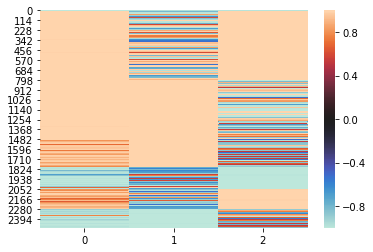

metacluster0
activity pattern: [1 0 1]
pattern_0
total seqlets: 609
Task 0 hypothetical scores:


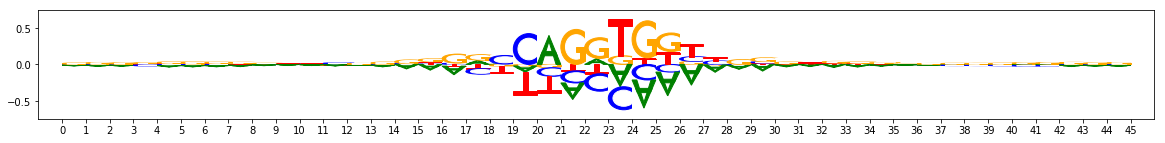

Task 0 actual importance scores:


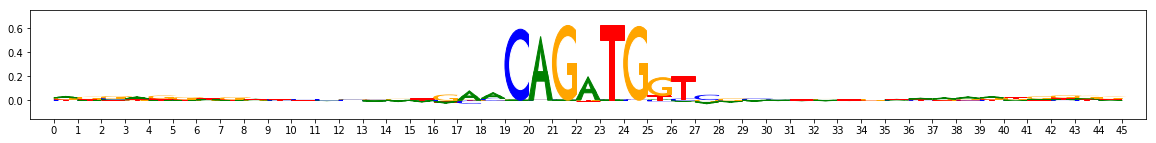

Task 1 hypothetical scores:


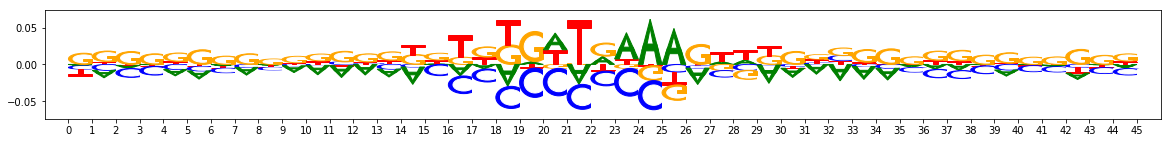

Task 1 actual importance scores:


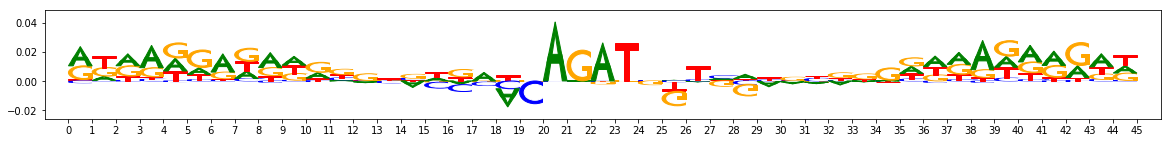

Task 2 hypothetical scores:


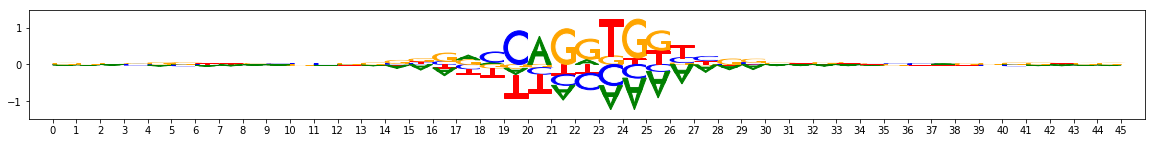

Task 2 actual importance scores:


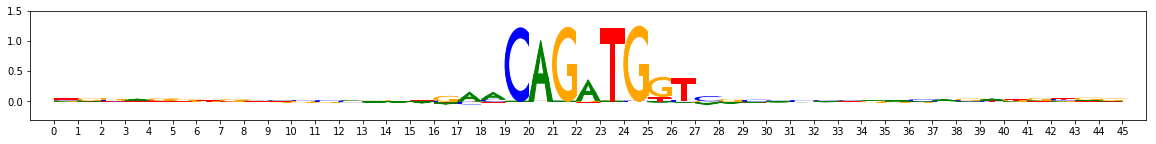

onehot, fwd and rev:


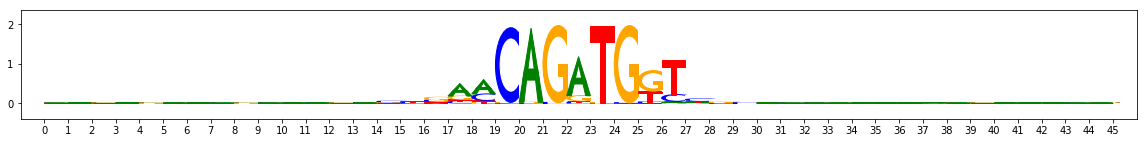

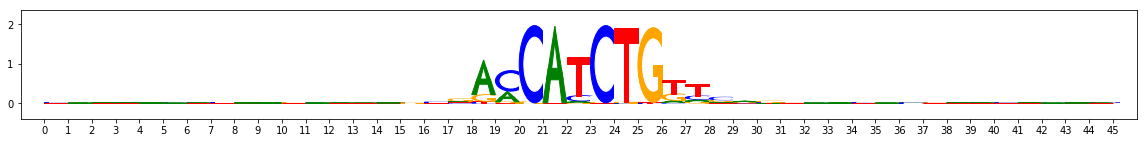

metacluster1
activity pattern: [1 1 0]
pattern_0
total seqlets: 466
Task 0 hypothetical scores:


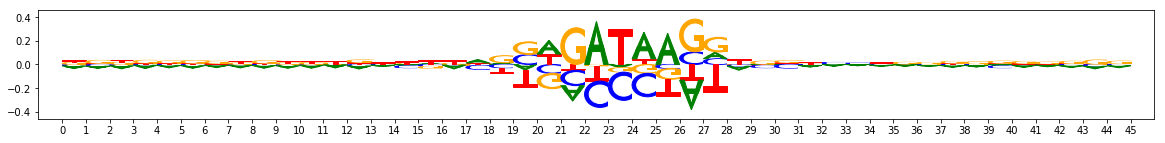

Task 0 actual importance scores:


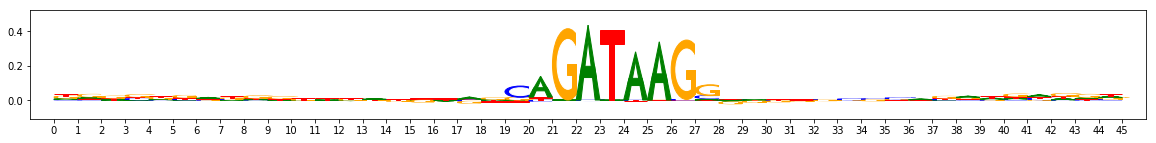

Task 1 hypothetical scores:


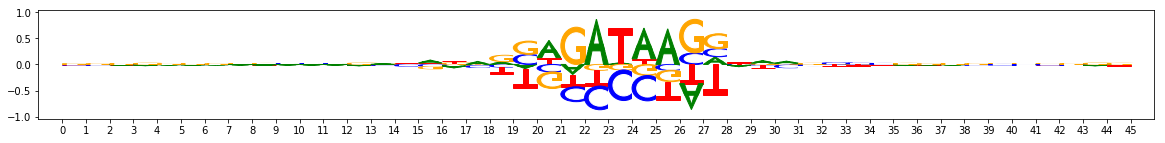

Task 1 actual importance scores:


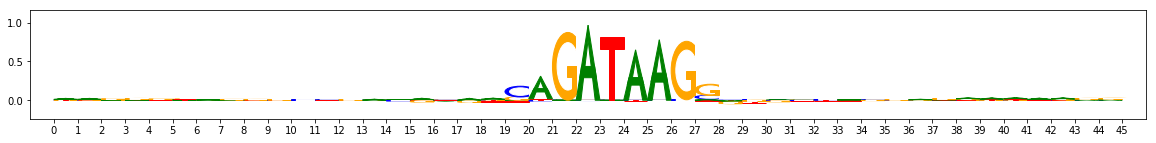

Task 2 hypothetical scores:


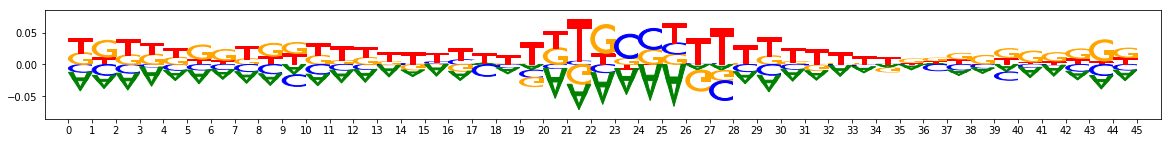

Task 2 actual importance scores:


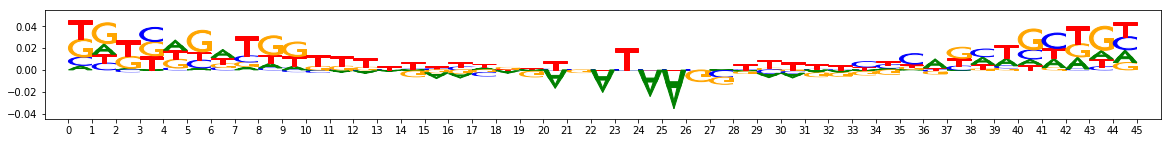

onehot, fwd and rev:


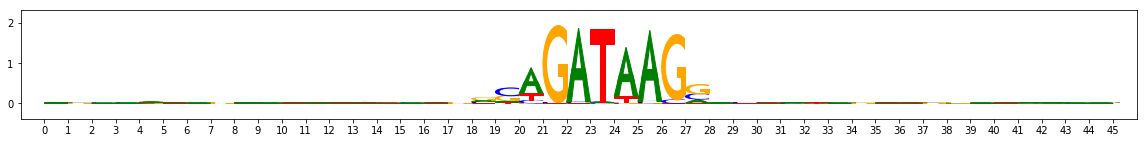

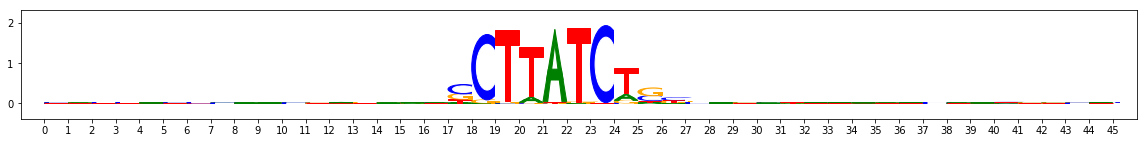

metacluster2
activity pattern: [0 1 0]
pattern_0
total seqlets: 134
Task 0 hypothetical scores:


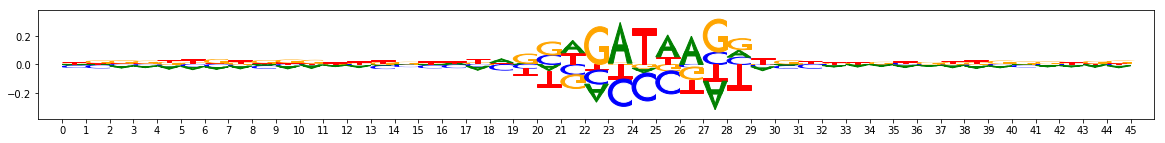

Task 0 actual importance scores:


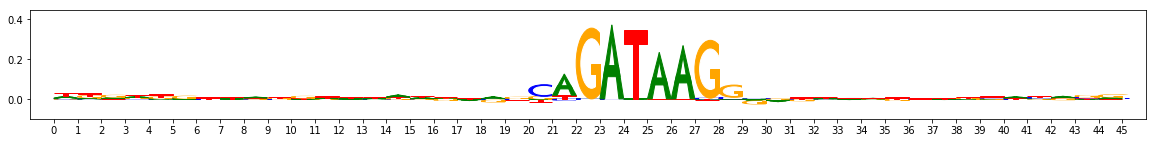

Task 1 hypothetical scores:


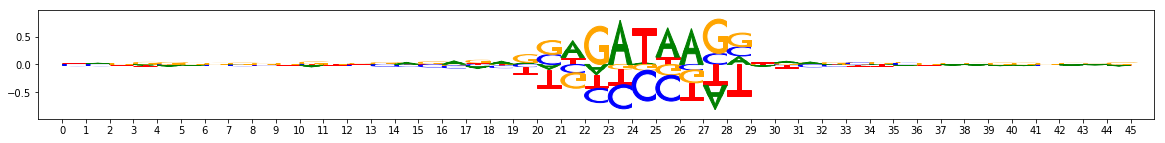

Task 1 actual importance scores:


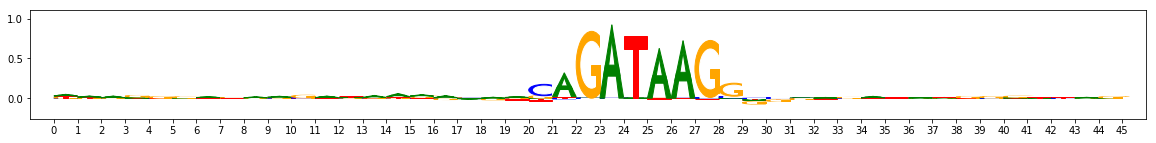

Task 2 hypothetical scores:


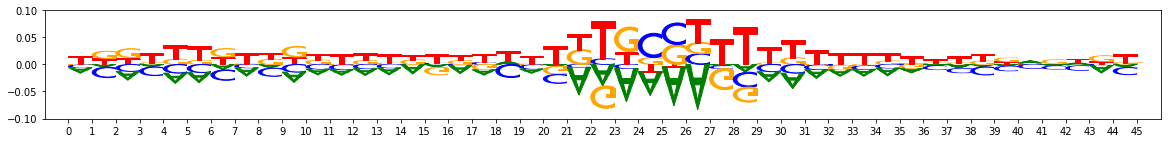

Task 2 actual importance scores:


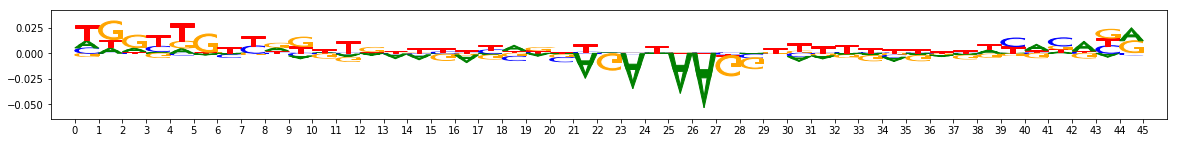

onehot, fwd and rev:


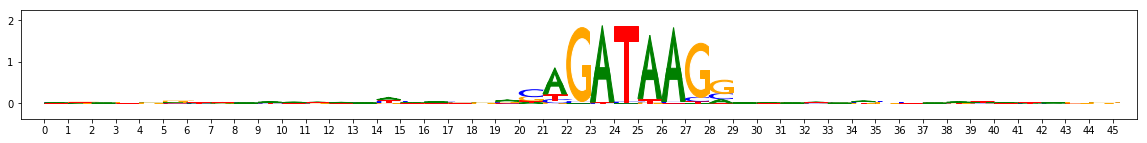

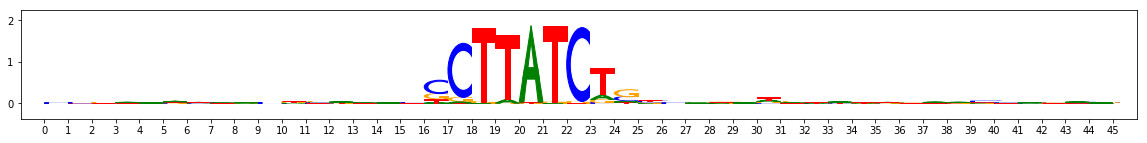

metacluster3
activity pattern: [ 0  0 -1]
No motifs found for this activity pattern
metacluster4
activity pattern: [0 0 1]
pattern_0
total seqlets: 143
Task 0 hypothetical scores:


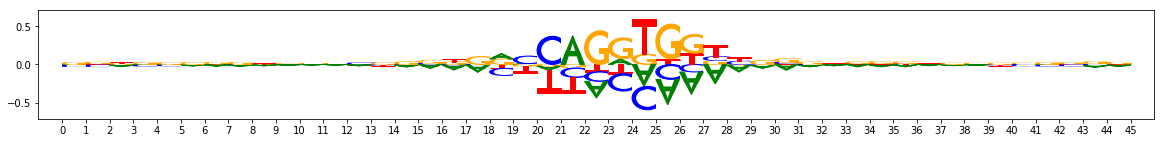

Task 0 actual importance scores:


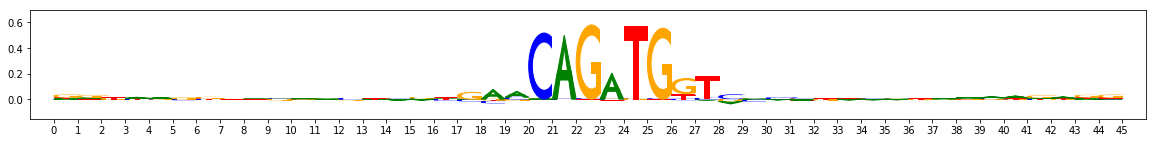

Task 1 hypothetical scores:


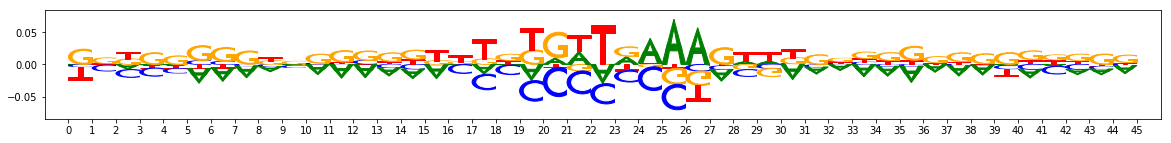

Task 1 actual importance scores:


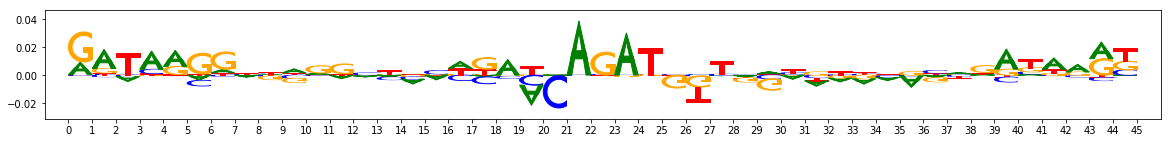

Task 2 hypothetical scores:


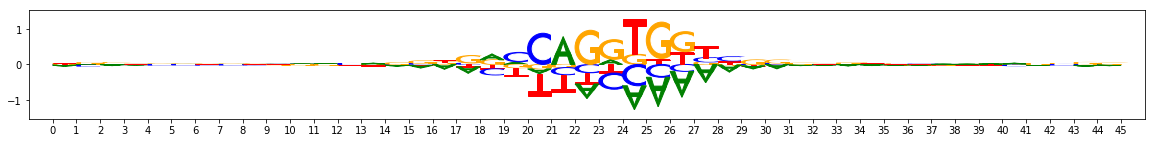

Task 2 actual importance scores:


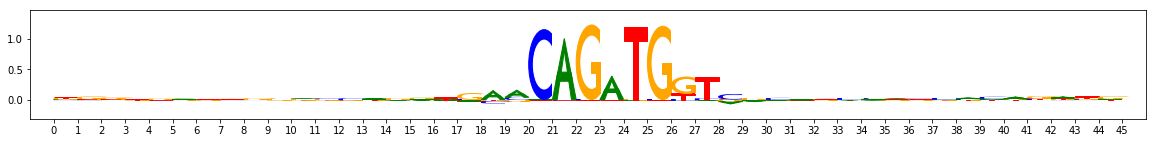

onehot, fwd and rev:


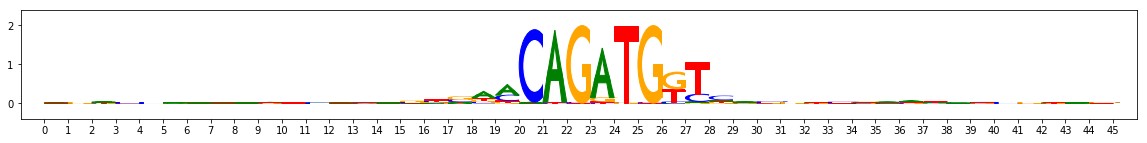

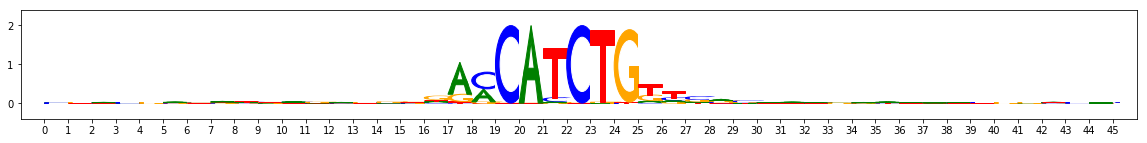

metacluster5
activity pattern: [ 0 -1  0]
No motifs found for this activity pattern


In [8]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5")

import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = list(hdf5_results["metaclustering_results"]["all_metacluster_names"][:])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = (list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:]))
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(pattern_name)
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()